In [1]:
# Do analyst recommendations correlate with stock performance?
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import sqlite3
from IPython.display import display
from sklearn.metrics import r2_score
pd.set_option('display.max_columns',500)

In [2]:
stock_tickers = ['FB','AAPL','AMZN','NFLX','GOOGL','DIS','CBRL','HBI','XOM']
stock_ticker='GOOG'
period = '5y'

In [3]:
def process_individual_stock(stock_ticker,period='5y',days_out=180,color_method='Auto',qlow=0.15,qhigh=0.85,vmin=2.75,vmax=3.75,min_returns=5):
    # Prepare yfinance
    print('Results for: '+stock_ticker)
    stock=yf.Ticker(stock_ticker)
    
    # Get historical trading data
    history=stock.history(period=period)
    history
    
    # Get recommendations
    days_out = days_out
    recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
    recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
    recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
    recommendations['Good Until']=recommendations[['Next Recommendation',str(days_out)+' Days From']].max(axis=1) # Define how long a recommendation lasts for - lowest of [180 days] or [Until a new recommendation by that firm]

    # Process the recommendation values
    print('Recommendation values: '+str(sorted(recommendations['To Grade'].dropna().unique()))) # Print out the unique recommendation grades
    assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
       'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
       'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Underperform':1,
       'Underweight':1} # Create numeric representations of the recommendations
    recommendations['Assigned Value']=recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
    
    # Store the dataframes in sqlite memory
    conn = sqlite3.connect(':memory:')
    history.to_sql('history', conn, index=True)
    recommendations.to_sql('recommendations', conn, index=False)
    
    # Get average analyst assigned scores by day using SQL
    qry = '''
    select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value'
    from history h
    left join ( 
    select * from recommendations r 
    where r.firm in (select firm from recommendations group by firm having count(date)>=5) -- Join recommendations, but only for firms with at least 5 recommendations
    ) r
    on date(h.date) between date(r.date) and date(r.'good until')
    group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
        '''
    df = pd.read_sql_query(qry, conn).sort_values(by='Date')
    df['Date']=pd.to_datetime(df['Date'])

        
    # Make a plot with background color estimating recommendation sentiment for the periods
    # This considers the average recommendation overall
    fig,ax = plt.subplots()
    df.plot(figsize=(16,16),x='Date',y='Close',ax=ax)
    # # Originally used a list color map but change to a scalar map
    colormap=colors.LinearSegmentedColormap.from_list('custom',['Red','Yellow','Green'])
    # vmin, vmax = 2.5, 4.5 # Manual color definition
    if color_method == 'Auto':
        qlow = qlow
        qhigh = qhigh
        vmin = df['Average Assigned Value'].quantile(qlow) # Color definition using quantiles (low)
        vmax = df['Average Assigned Value'].quantile(qhigh) # Color definition using quantiles (high)
    elif color_method == 'Manual':
        vmin = vmin
        vmax = vmax
    else:
        print('Error: Please choose Auto or Manual to define your color scheme.')
        return
    normalize = colors.Normalize(vmin=vmin,vmax=vmax)
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    for idx, row in df.iterrows():
        ax.axvspan(row['Date'],row['Date']+pd.DateOffset(days=1),alpha=0.2,color=scalarmappaple.to_rgba(row['Average Assigned Value']))
    cbar=plt.colorbar(scalarmappaple,label='Average Analyst Recommendation',extend='both',fraction=0.046, pad=0.04)
    plt.show()
    
    # Get a correlation matrix of the current columns
    df['Returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1) # Day returns
    print('Correlation matrix for all data:')
    display(df.corr())
    
    # Process the dataframe to get columns that can be grouped on the analyst average recommendation to show how it affects returns
    df['Track Difference Up'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(1),0,1)
    df['Track Difference Down'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(-1),0,1)
    df['Track Difference Unique'] = df['Track Difference Up'].cumsum()
    df['First Open'] = np.where(df['Track Difference Up']==1,df['Open'],None)
    df['Last Close'] = np.where(df['Track Difference Down']==1,df['Close'],None)
    
    # Get a grouped dataframe with returns data by average analyst recommendation
    returns_df = df.groupby(['Track Difference Unique','Average Assigned Value']).agg({'First Open':'min','Last Close':'max','Returns':'count'}).reset_index()
    returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
    returns_df['Daily Return']=100*(1-returns_df['Total Return Fraction']**(1/returns_df['Returns'])) # Get the daily return rate for the period by taking the n-th root of n-day cumulative stock movements and subtracting 1 (remember the compound interest equation)
    
    # Create a dataframe that has at least the minimum days (otherwise 1-day moves could yield high variance, potentially leading to false conclusions)
    min_returns = min_returns
    min_returns_df = returns_df[returns_df['Returns']>=min_returns]
    min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
    m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
    plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
    title = 'R2 Score: '+str(round(r2_score(min_returns_df['Daily Return'],min_returns_df['Average Assigned Value']*m+b),4))
    plt.title(title)
    plt.show()
    print('Correlation matrix for processed returns data:')
    display(min_returns_df.corr())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Results for: FB
Recommendation values: ['Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Mixed', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Reduce', 'Sector Perform', 'Sell', 'Strong Buy']


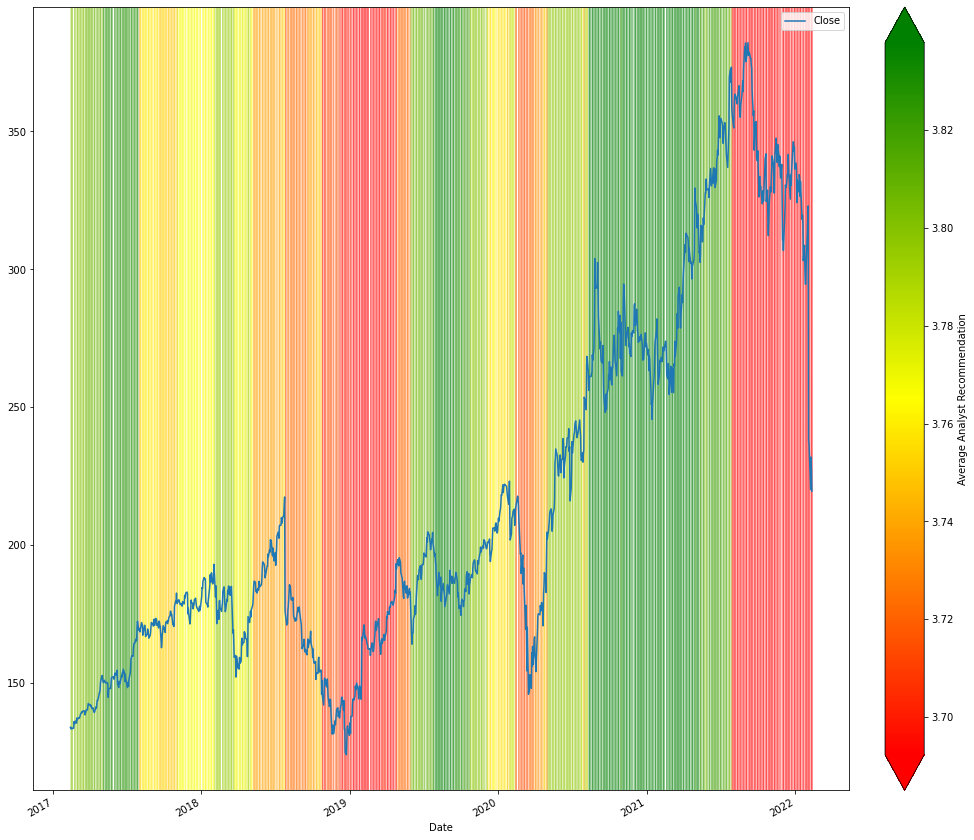

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999337,0.999242,0.998537,-0.062736,-0.069098,-0.010745
High,0.999337,1.000000,0.999083,0.999284,-0.052076,-0.069383,0.004987
Low,0.999242,0.999083,1.000000,0.999333,-0.077008,-0.068484,0.009625
Close,0.998537,0.999284,0.999333,1.000000,-0.065796,-0.068495,0.026931
Volume,-0.062736,-0.052076,-0.077008,-0.065796,1.000000,-0.142643,-0.197790
Average Assigned Value,-0.069098,-0.069383,-0.068484,-0.068495,-0.142643,1.000000,0.054414
Returns,-0.010745,0.004987,0.009625,0.026931,-0.197790,0.054414,1.000000


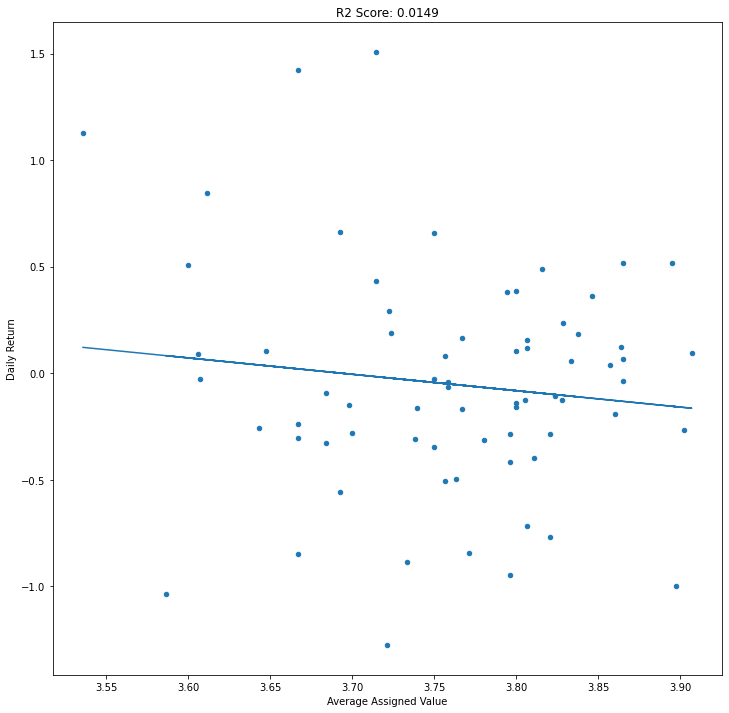

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,-0.192100,0.892792,0.881791,-0.315366,-0.050011,0.097612
Average Assigned Value,-0.192100,1.000000,-0.139661,-0.115696,0.141826,0.098928,-0.122140
First Open,0.892792,-0.139661,1.000000,0.976136,-0.231121,-0.100806,0.202997
Last Close,0.881791,-0.115696,0.976136,1.000000,-0.201979,0.110174,0.011180
Returns,-0.315366,0.141826,-0.231121,-0.201979,1.000000,0.107079,-0.008742
Total Return Fraction,-0.050011,0.098928,-0.100806,0.110174,0.107079,1.000000,-0.855687
Daily Return,0.097612,-0.122140,0.202997,0.011180,-0.008742,-0.855687,1.000000


Done
Results for: AAPL
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-Term Buy', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Negative', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


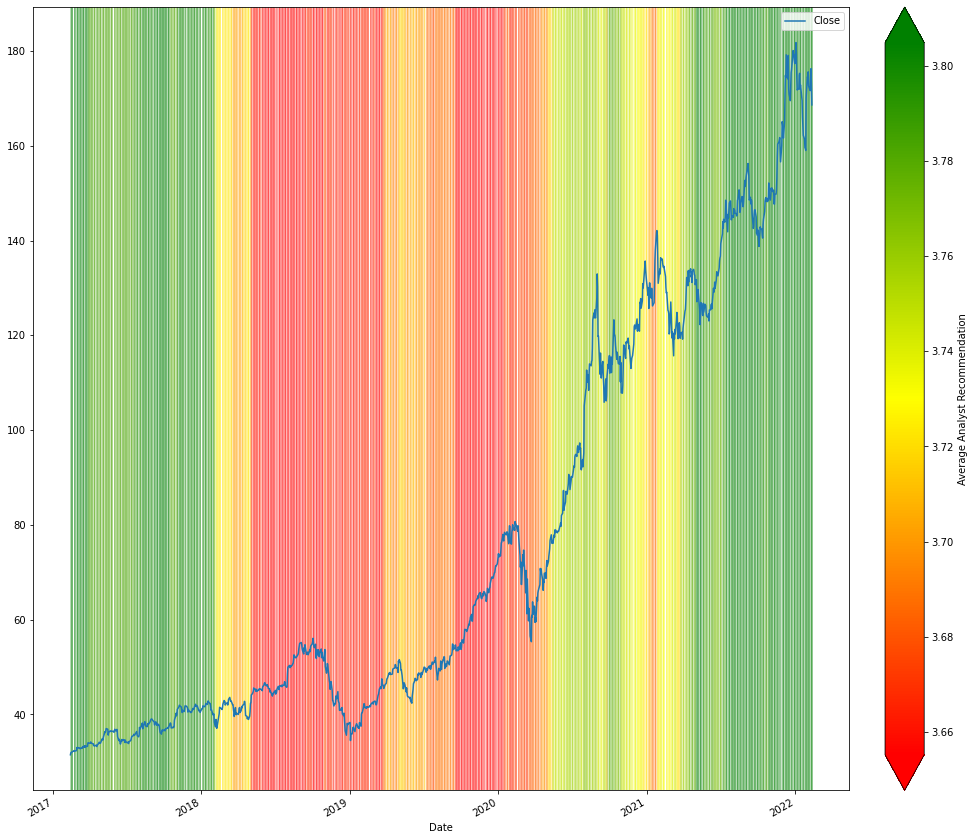

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999820,0.999745,0.999535,-0.154827,0.450036,0.005759
High,0.999820,1.000000,0.999690,0.999759,-0.147943,0.449105,0.013324
Low,0.999745,0.999690,1.000000,0.999763,-0.163883,0.451106,0.015162
Close,0.999535,0.999759,0.999763,1.000000,-0.156420,0.449826,0.026095
Volume,-0.154827,-0.147943,-0.163883,-0.156420,1.000000,-0.195679,-0.083344
Average Assigned Value,0.450036,0.449105,0.451106,0.449826,-0.195679,1.000000,-0.005452
Returns,0.005759,0.013324,0.015162,0.026095,-0.083344,-0.005452,1.000000


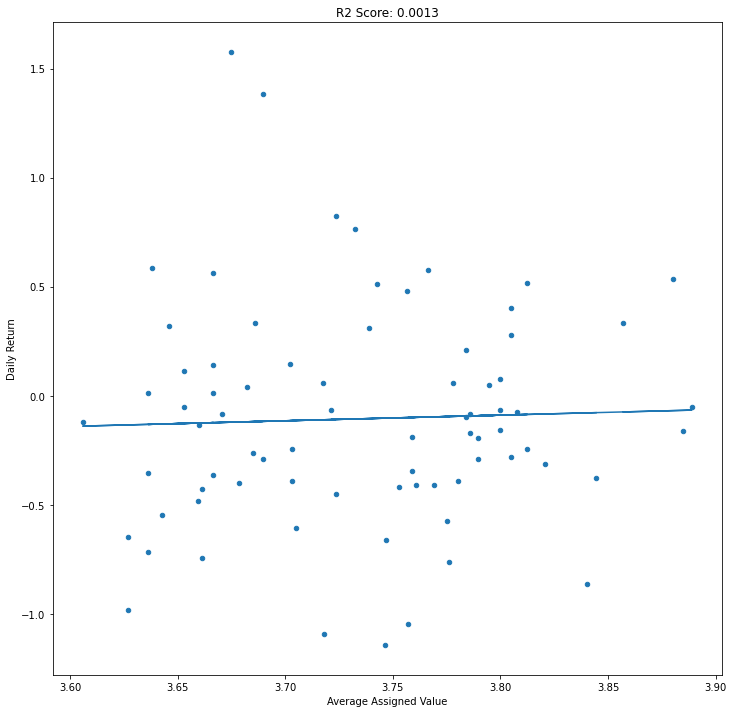

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.415153,0.949634,0.949604,-0.291047,-0.142962,0.027913
Average Assigned Value,0.415153,1.000000,0.573573,0.576351,0.099912,-0.015687,0.035611
First Open,0.949634,0.573573,1.000000,0.995938,-0.212810,-0.177906,0.087967
Last Close,0.949604,0.576351,0.995938,1.000000,-0.203686,-0.098570,0.012021
Returns,-0.291047,0.099912,-0.212810,-0.203686,1.000000,0.240927,-0.009039
Total Return Fraction,-0.142962,-0.015687,-0.177906,-0.098570,0.240927,1.000000,-0.916377
Daily Return,0.027913,0.035611,0.087967,0.012021,-0.009039,-0.916377,1.000000


Done
Results for: AMZN
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Fair Value', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Sector Weight', 'Sell', 'Strong Buy']


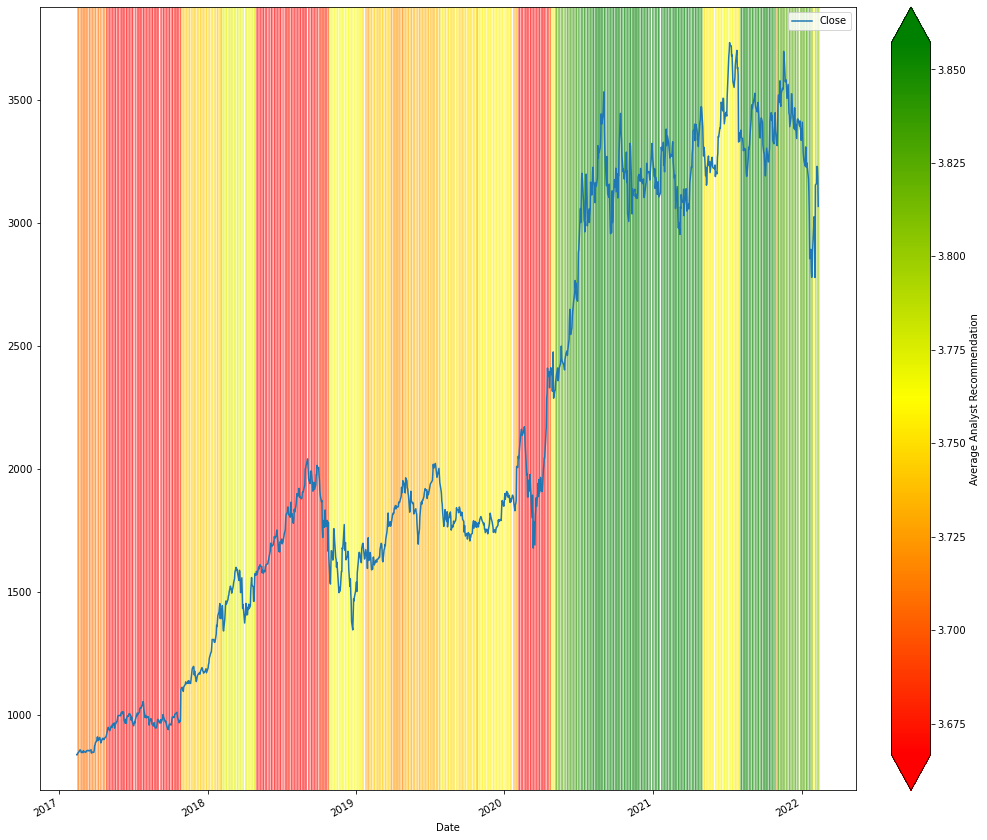

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999658,0.999546,0.999145,-0.079650,0.774813,-0.031244
High,0.999658,1.000000,0.999446,0.999589,-0.070134,0.775404,-0.018172
Low,0.999546,0.999446,1.000000,0.999598,-0.092746,0.773281,-0.015979
Close,0.999145,0.999589,0.999598,1.000000,-0.081554,0.774314,-0.001088
Volume,-0.079650,-0.070134,-0.092746,-0.081554,1.000000,-0.043937,-0.020691
Average Assigned Value,0.774813,0.775404,0.773281,0.774314,-0.043937,1.000000,-0.008982
Returns,-0.031244,-0.018172,-0.015979,-0.001088,-0.020691,-0.008982,1.000000


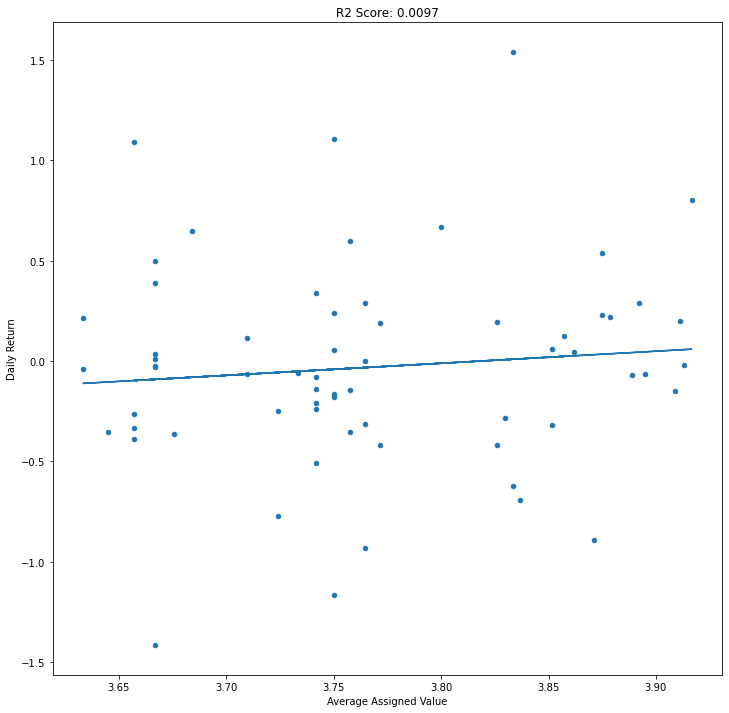

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.707954,0.958520,0.950226,-0.212345,-0.206034,0.288133
Average Assigned Value,0.707954,1.000000,0.757429,0.755790,-0.175876,-0.118568,0.098410
First Open,0.958520,0.757429,1.000000,0.989149,-0.235705,-0.229313,0.294284
Last Close,0.950226,0.755790,0.989149,1.000000,-0.229568,-0.091049,0.171218
Returns,-0.212345,-0.175876,-0.235705,-0.229568,1.000000,0.082847,-0.041402
Total Return Fraction,-0.206034,-0.118568,-0.229313,-0.091049,0.082847,1.000000,-0.883165
Daily Return,0.288133,0.098410,0.294284,0.171218,-0.041402,-0.883165,1.000000


Done
Results for: NFLX
Recommendation values: ['', 'Average', 'Below Average', 'Buy', 'Equal-Weight', 'Equal-weight', 'Fair Value', 'Hold', 'In-Line', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


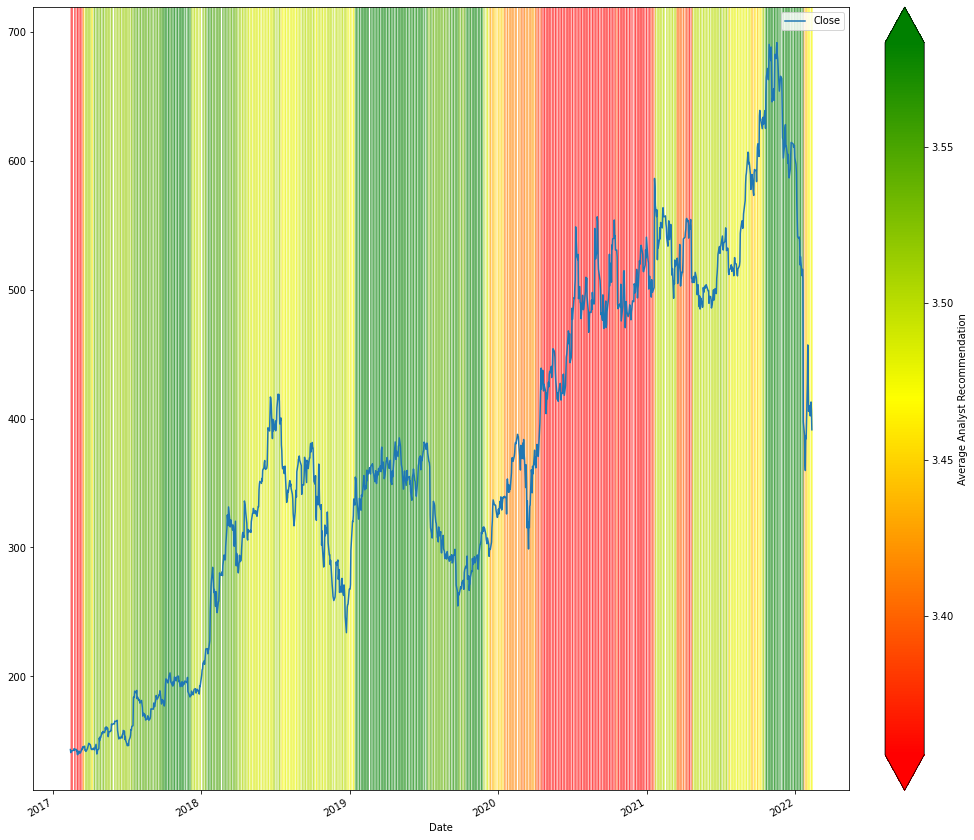

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999276,0.999213,0.998366,-0.222743,-0.285198,-0.036869
High,0.999276,1.000000,0.999025,0.999251,-0.210183,-0.289668,-0.016945
Low,0.999213,0.999025,1.000000,0.999238,-0.235644,-0.282960,-0.014633
Close,0.998366,0.999251,0.999238,1.000000,-0.220327,-0.287627,0.006756
Volume,-0.222743,-0.210183,-0.235644,-0.220327,1.000000,0.069886,0.001548
Average Assigned Value,-0.285198,-0.289668,-0.282960,-0.287627,0.069886,1.000000,-0.002881
Returns,-0.036869,-0.016945,-0.014633,0.006756,0.001548,-0.002881,1.000000


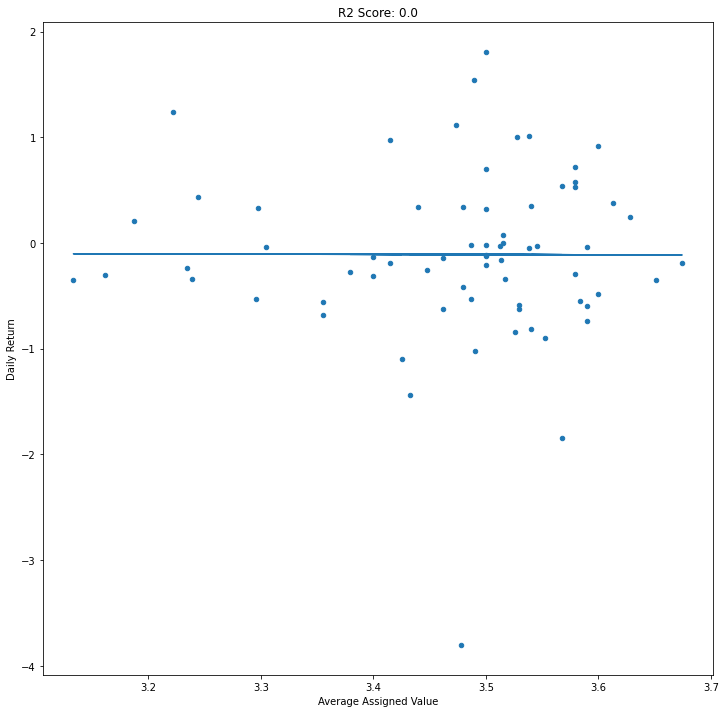

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,-0.361313,0.919321,0.911588,-0.038656,-0.088153,0.063545
Average Assigned Value,-0.361313,1.000000,-0.310157,-0.325669,0.122216,-0.000559,-0.003147
First Open,0.919321,-0.310157,1.000000,0.971870,-0.015072,-0.172947,0.175550
Last Close,0.911588,-0.325669,0.971870,1.000000,0.003529,0.050794,-0.004488
Returns,-0.038656,0.122216,-0.015072,0.003529,1.000000,0.085824,0.056961
Total Return Fraction,-0.088153,-0.000559,-0.172947,0.050794,0.085824,1.000000,-0.830740
Daily Return,0.063545,-0.003147,0.175550,-0.004488,0.056961,-0.830740,1.000000


Done
Results for: GOOGL
Recommendation values: ['Buy', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Underperform']


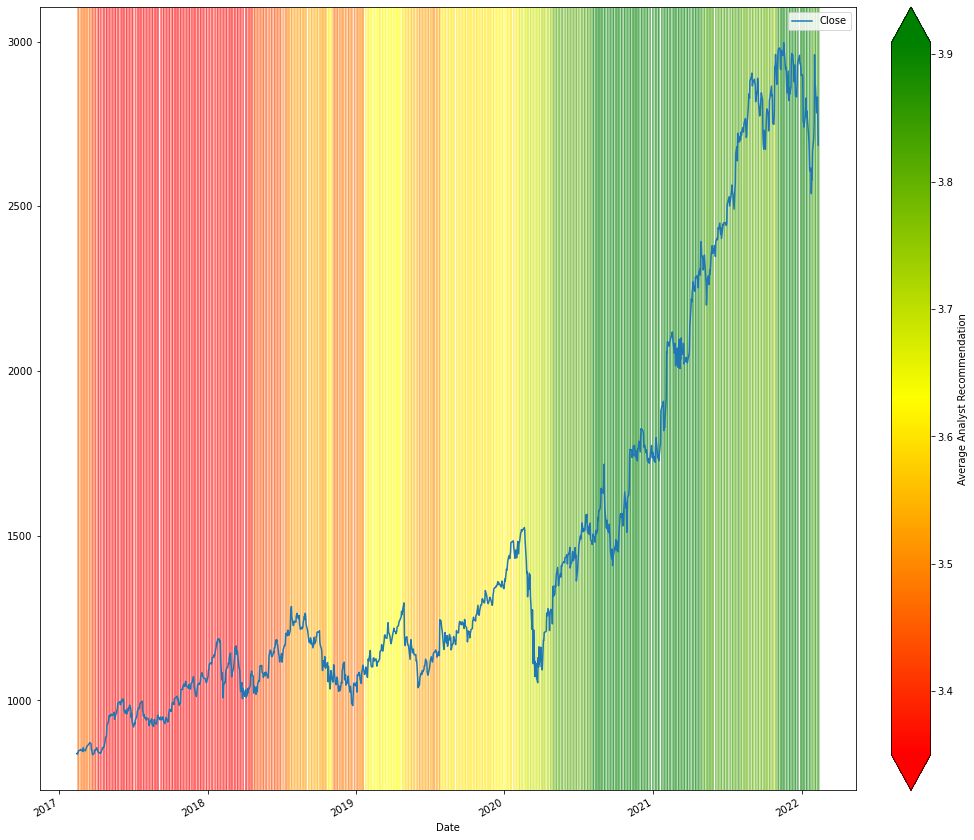

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999738,0.999691,0.999413,-0.109765,0.733333,0.005710
High,0.999738,1.000000,0.999606,0.999691,-0.102672,0.736469,0.015719
Low,0.999691,0.999606,1.000000,0.999734,-0.120191,0.731874,0.017822
Close,0.999413,0.999691,0.999734,1.000000,-0.112894,0.734180,0.029229
Volume,-0.109765,-0.102672,-0.120191,-0.112894,1.000000,-0.034839,-0.049349
Average Assigned Value,0.733333,0.736469,0.731874,0.734180,-0.034839,1.000000,0.022449
Returns,0.005710,0.015719,0.017822,0.029229,-0.049349,0.022449,1.000000


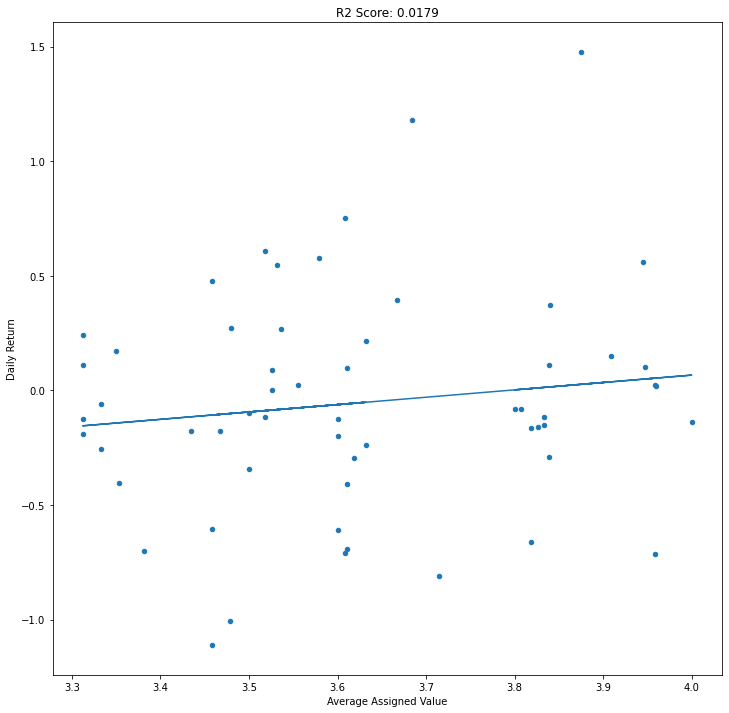

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.917980,0.888864,0.887284,-0.027169,-0.136028,0.177587
Average Assigned Value,0.917980,1.000000,0.748243,0.757432,0.000372,-0.076118,0.133767
First Open,0.888864,0.748243,1.000000,0.982353,0.042997,-0.199534,0.270833
Last Close,0.887284,0.757432,0.982353,1.000000,0.080419,-0.025275,0.131053
Returns,-0.027169,0.000372,0.042997,0.080419,1.000000,0.240641,-0.007366
Total Return Fraction,-0.136028,-0.076118,-0.199534,-0.025275,0.240641,1.000000,-0.786051
Daily Return,0.177587,0.133767,0.270833,0.131053,-0.007366,-0.786051,1.000000


Done
Results for: DIS
Recommendation values: ['', 'Average', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'In-Line', 'Long-Term Buy', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sector Perform', 'Sell', 'Top Pick', 'Underperform', 'Underweight']


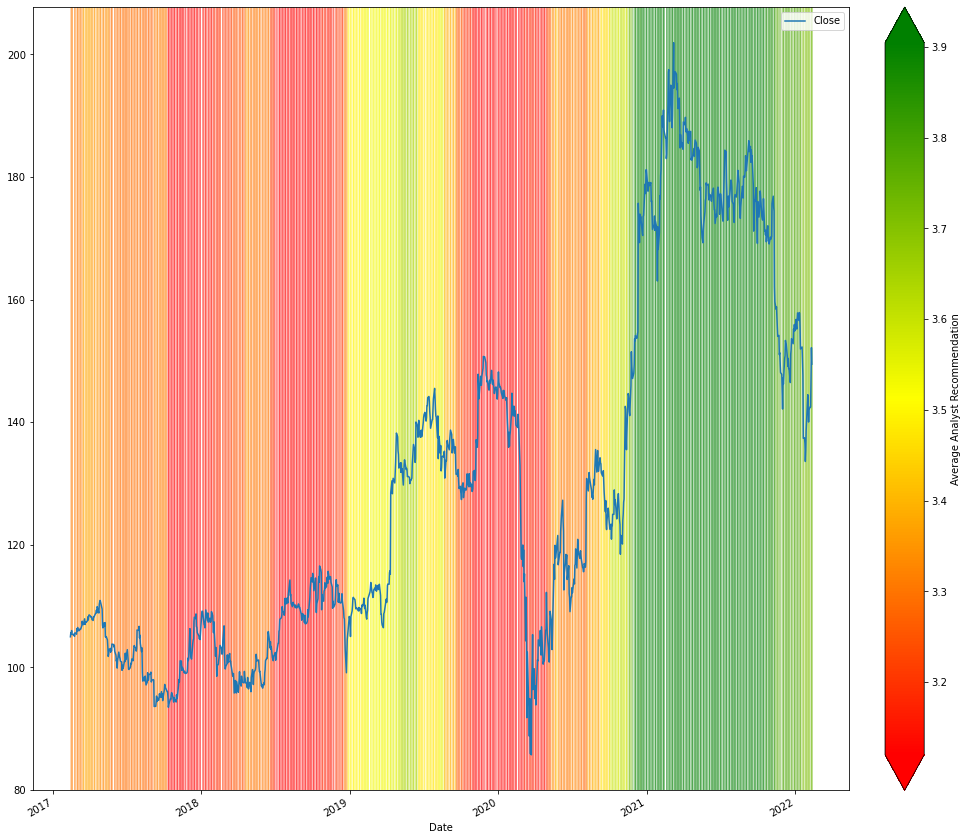

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999075,0.998994,0.998195,0.035402,0.766740,-0.007002
High,0.999075,1.000000,0.998471,0.999123,0.054065,0.768042,0.016592
Low,0.998994,0.998471,1.000000,0.998942,0.014912,0.766674,0.012290
Close,0.998195,0.999123,0.998942,1.000000,0.036947,0.768163,0.036915
Volume,0.035402,0.054065,0.014912,0.036947,1.000000,0.032115,0.105448
Average Assigned Value,0.766740,0.768042,0.766674,0.768163,0.032115,1.000000,0.014203
Returns,-0.007002,0.016592,0.012290,0.036915,0.105448,0.014203,1.000000


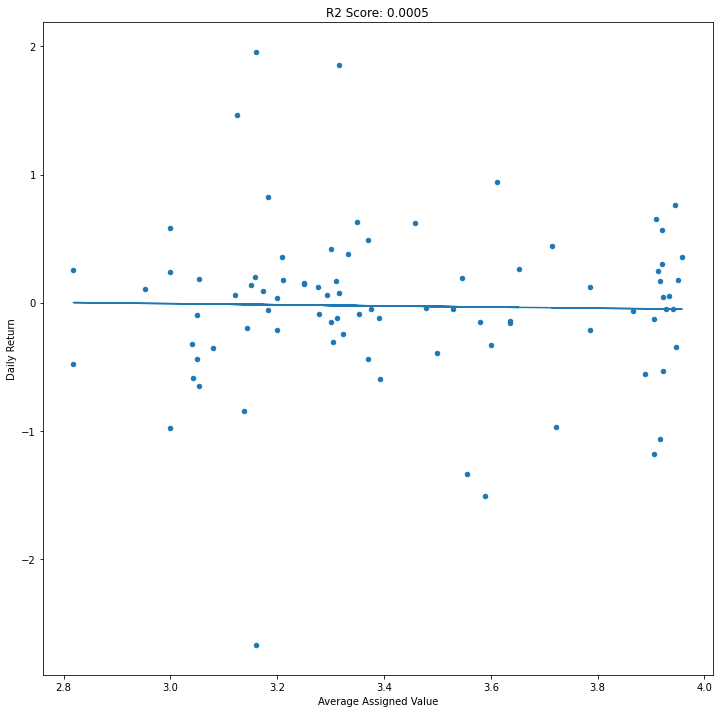

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.716722,0.826521,0.830430,-0.217991,0.002036,-0.032644
Average Assigned Value,0.716722,1.000000,0.742679,0.765175,-0.018340,0.070777,-0.023024
First Open,0.826521,0.742679,1.000000,0.974038,-0.109953,-0.148049,0.120445
Last Close,0.830430,0.765175,0.974038,1.000000,-0.112597,0.074554,-0.081043
Returns,-0.217991,-0.018340,-0.109953,-0.112597,1.000000,-0.002667,0.002181
Total Return Fraction,0.002036,0.070777,-0.148049,0.074554,-0.002667,1.000000,-0.909192
Daily Return,-0.032644,-0.023024,0.120445,-0.081043,0.002181,-0.909192,1.000000


Done
Results for: CBRL
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Underperform', 'Underweight']


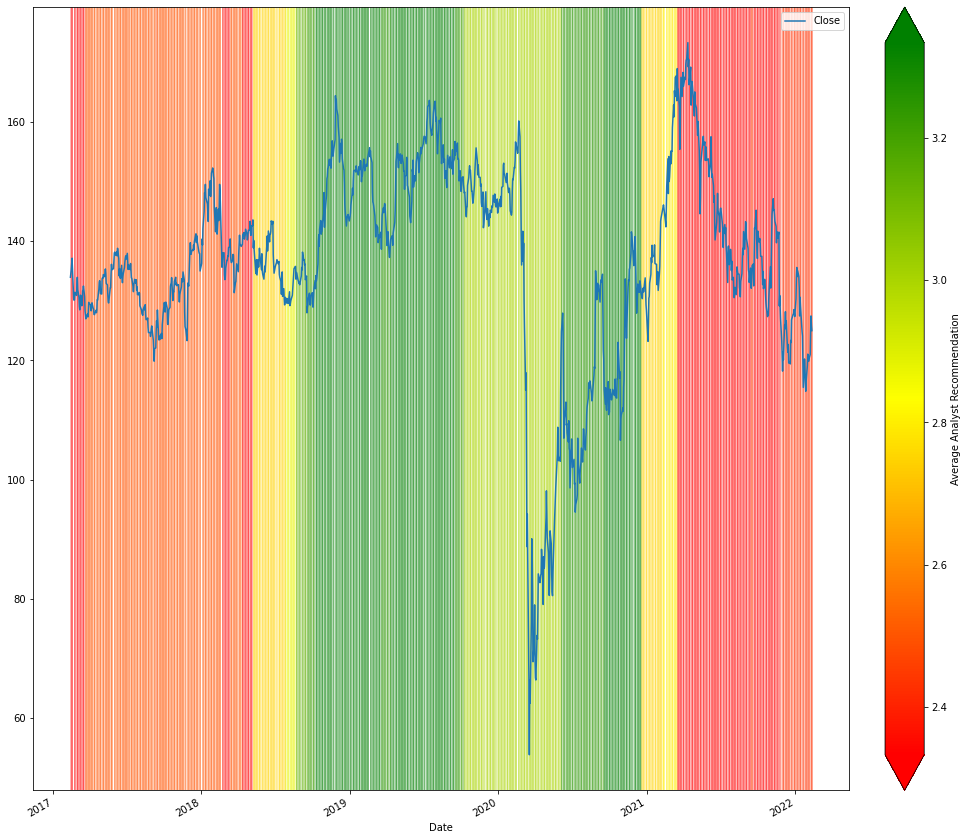

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.995338,0.995073,0.990584,-0.344772,0.001242,-0.058623
High,0.995338,1.000000,0.993763,0.994928,-0.313731,0.005902,-0.002260
Low,0.995073,0.993763,1.000000,0.996240,-0.377249,-0.002727,0.001544
Close,0.990584,0.994928,0.996240,1.000000,-0.353746,0.003591,0.053028
Volume,-0.344772,-0.313731,-0.377249,-0.353746,1.000000,0.243797,-0.040939
Average Assigned Value,0.001242,0.005902,-0.002727,0.003591,0.243797,1.000000,0.026164
Returns,-0.058623,-0.002260,0.001544,0.053028,-0.040939,0.026164,1.000000


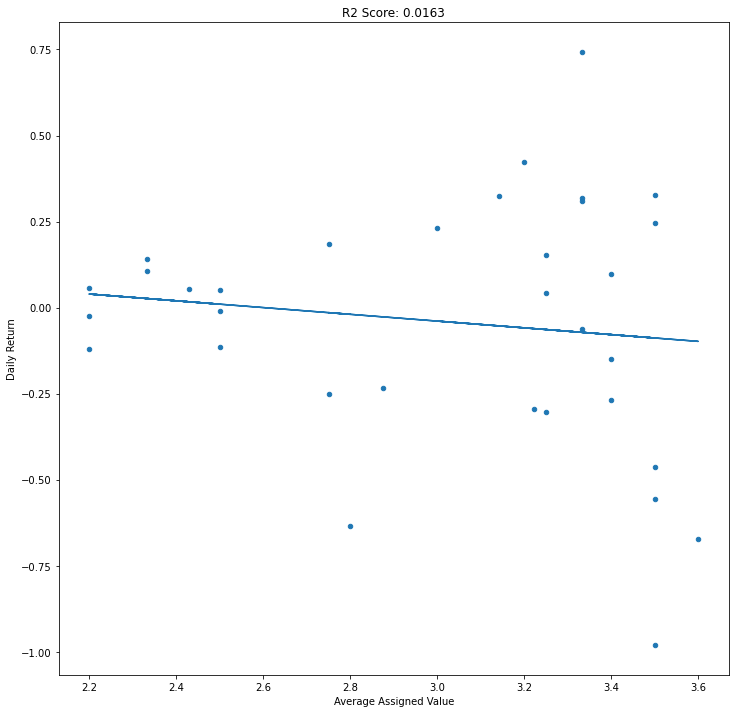

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.128582,-0.064170,-0.090573,0.063150,-0.001367,0.067947
Average Assigned Value,0.128582,1.000000,0.072041,0.240997,-0.361768,0.176818,-0.127839
First Open,-0.064170,0.072041,1.000000,0.500699,0.024180,-0.502131,0.172311
Last Close,-0.090573,0.240997,0.500699,1.000000,-0.396149,0.489700,-0.488491
Returns,0.063150,-0.361768,0.024180,-0.396149,1.000000,-0.359428,0.105918
Total Return Fraction,-0.001367,0.176818,-0.502131,0.489700,-0.359428,1.000000,-0.669903
Daily Return,0.067947,-0.127839,0.172311,-0.488491,0.105918,-0.669903,1.000000


Done
Results for: HBI
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


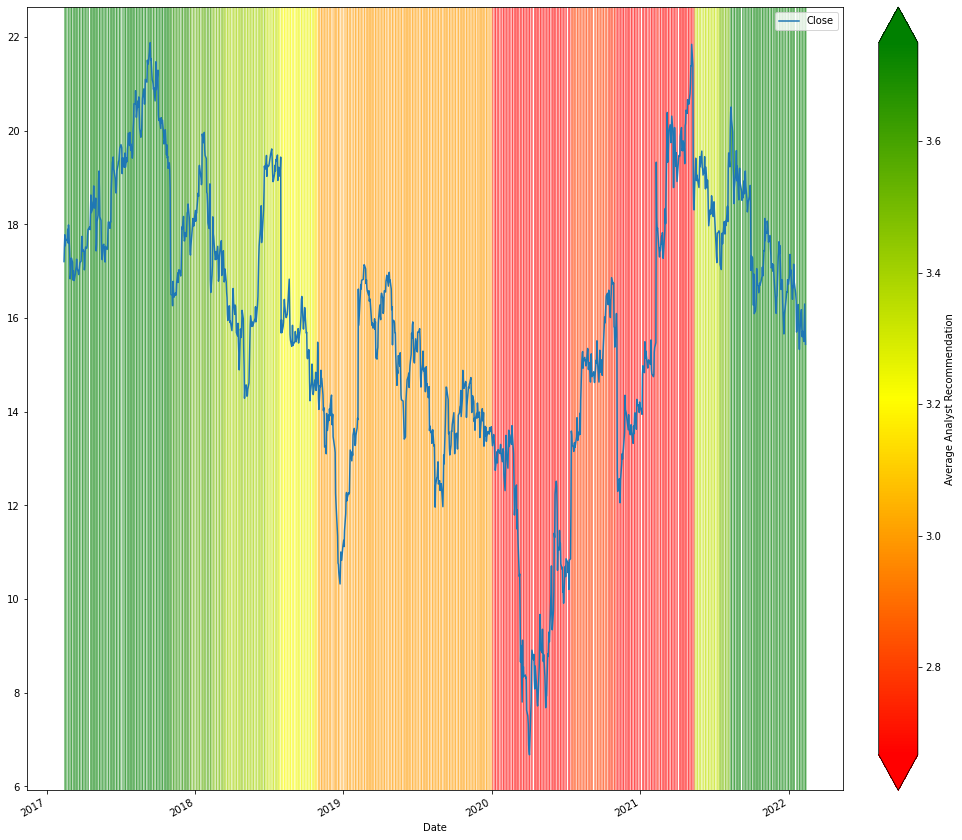

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.997183,0.996890,0.993854,-0.289639,0.685131,-0.030937
High,0.997183,1.000000,0.996302,0.996902,-0.267267,0.681357,0.010786
Low,0.996890,0.996302,1.000000,0.997391,-0.312419,0.688182,0.014906
Close,0.993854,0.996902,0.997391,1.000000,-0.292376,0.682254,0.057245
Volume,-0.289639,-0.267267,-0.312419,-0.292376,1.000000,-0.204168,-0.042173
Average Assigned Value,0.685131,0.681357,0.688182,0.682254,-0.204168,1.000000,-0.022999
Returns,-0.030937,0.010786,0.014906,0.057245,-0.042173,-0.022999,1.000000


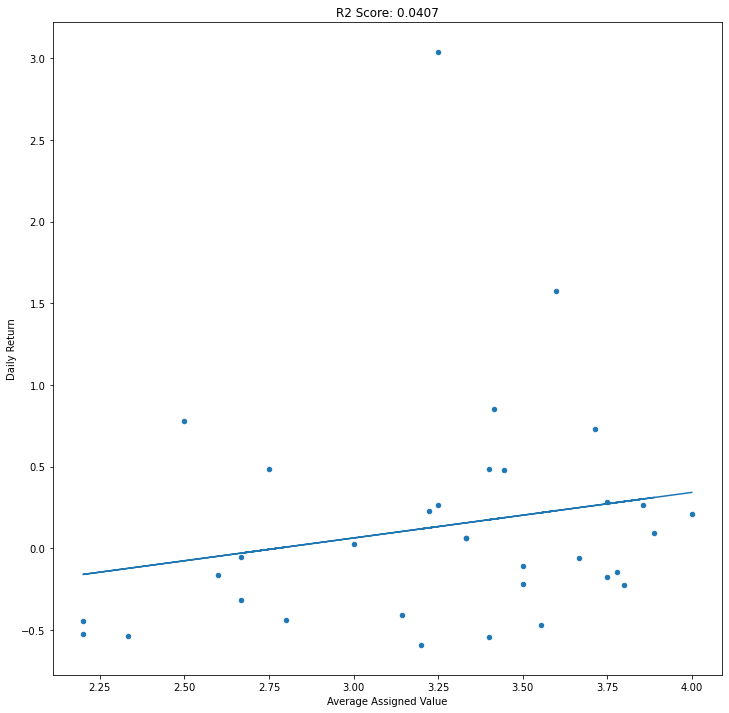

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,-0.431972,-0.306689,-0.316145,0.121679,0.035300,-0.162741
Average Assigned Value,-0.431972,1.000000,0.819312,0.719230,-0.085244,-0.245178,0.201726
First Open,-0.306689,0.819312,1.000000,0.833912,-0.058054,-0.376759,0.422930
Last Close,-0.316145,0.719230,0.833912,1.000000,-0.035322,0.185152,0.013717
Returns,0.121679,-0.085244,-0.058054,-0.035322,1.000000,0.018784,-0.137401
Total Return Fraction,0.035300,-0.245178,-0.376759,0.185152,0.018784,1.000000,-0.670727
Daily Return,-0.162741,0.201726,0.422930,0.013717,-0.137401,-0.670727,1.000000


Done
Results for: XOM
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Underperform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


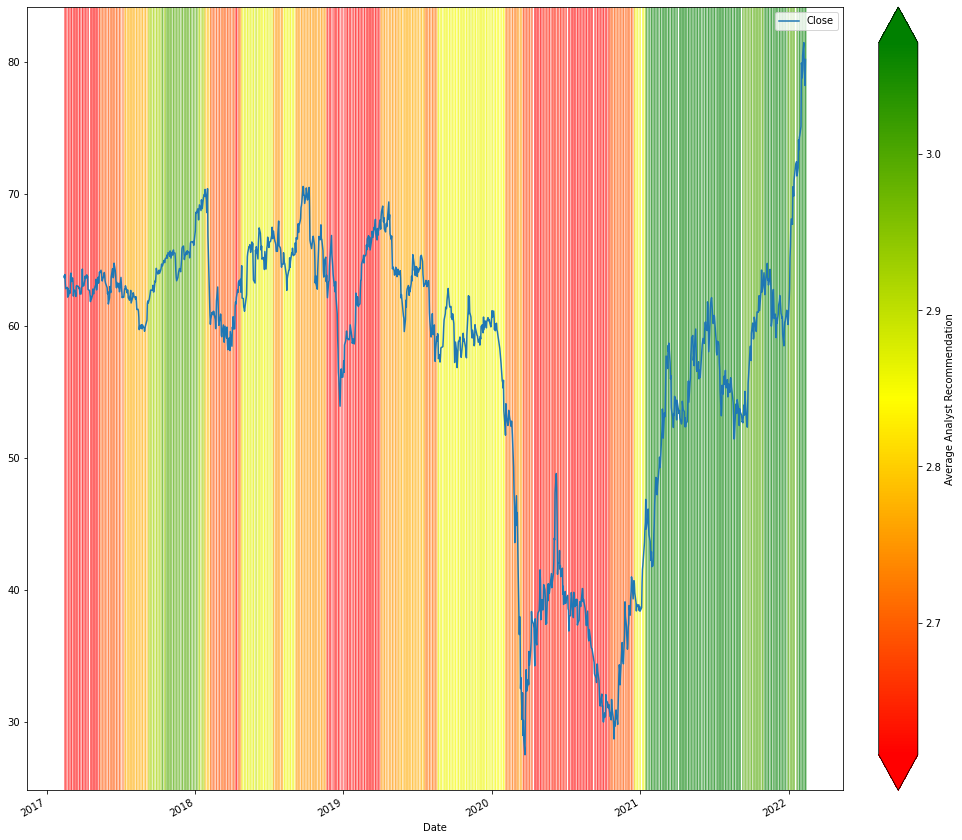

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998952,0.998880,0.997734,-0.588693,0.289386,-0.004799
High,0.998952,1.000000,0.998532,0.998943,-0.573593,0.298474,0.018486
Low,0.998880,0.998532,1.000000,0.998938,-0.603926,0.286476,0.019441
Close,0.997734,0.998943,0.998938,1.000000,-0.587835,0.293940,0.044325
Volume,-0.588693,-0.573593,-0.603926,-0.587835,1.000000,0.133509,0.016176
Average Assigned Value,0.289386,0.298474,0.286476,0.293940,0.133509,1.000000,0.048929
Returns,-0.004799,0.018486,0.019441,0.044325,0.016176,0.048929,1.000000


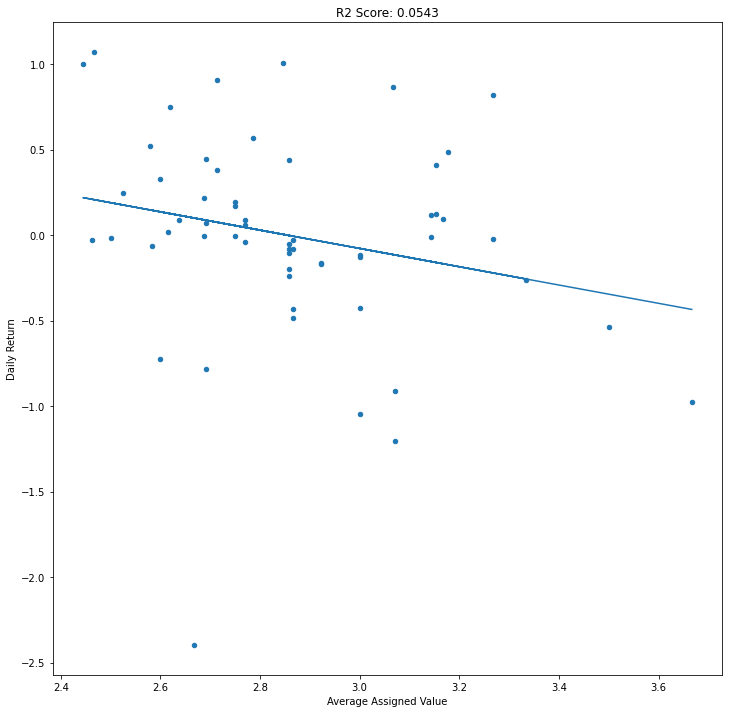

Correlation matrix for processed returns data:


,Track Difference Unique,Average Assigned Value,First Open,Last Close,Returns,Total Return Fraction,Daily Return
Track Difference Unique,1.000000,0.548056,-0.372084,-0.305361,-0.260170,0.159790,-0.069715
Average Assigned Value,0.548056,1.000000,0.415000,0.469502,-0.149094,0.198736,-0.232962
First Open,-0.372084,0.415000,1.000000,0.954730,0.196855,-0.084495,-0.005789
Last Close,-0.305361,0.469502,0.954730,1.000000,0.245850,0.205210,-0.237318
Returns,-0.260170,-0.149094,0.196855,0.245850,1.000000,0.180043,-0.028180
Total Return Fraction,0.159790,0.198736,-0.084495,0.205210,0.180043,1.000000,-0.826060
Daily Return,-0.069715,-0.232962,-0.005789,-0.237318,-0.028180,-0.826060,1.000000


Done


In [4]:
for i in stock_tickers:
    process_individual_stock(i)

In [5]:
# history=stock.history(period=period)
# history

In [6]:
# # Get recommendations
# days_out = 180
# recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
# recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
# recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
# recommendations['Good Until']=recommendations[['Next Recommendation',str(days_out)+' Days From']].max(axis=1) # Define how long a recommendation lasts for - lowest of [180 days] or [Until a new recommendation by that firm]
# recommendations

In [7]:
# print(sorted(recommendations['To Grade'].dropna().unique())) # Print out the unique recommendation grades
# assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
#        'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
#        'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Underperform':1,
#        'Underweight':1} # Create numeric representations of the recommendations
# recommendations['Assigned Value']=recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
# recommendations

In [8]:
# conn = sqlite3.connect(':memory:')
# history.to_sql('history', conn, index=True)
# recommendations.to_sql('recommendations', conn, index=False)

In [9]:
# # Use SQL to join on dates and to create a day column
# # Only keep recommendations for firms with at least 5 recommendations (in the SQL)

# qry = '''
# select h.open, h.high, h.low, h.close, h.volume, r.firm, date(h.date) as Date, 
# --julianday(date(h.date))-julianday('2012-01-01') as 'Day Value', -- not using this column for date axis
# r.action, r.'to grade', r.'from grade', date(r.'good until') as 'Good Until Date',
# --julianday(date(r.'good until'))-julianday('2012-01-01') as 'Good Until Day Value' -- not using this column for date axis
# r.'assigned value'
# from history h
# left join ( 
# select * from recommendations r 
# where r.firm in (select firm from recommendations group by firm having count(date)>=5) -- Join recommendations, but only for firms with at least 5 recommendations
# ) r
# on date(h.date) = date(r.date)
#     '''
# df = pd.read_sql_query(qry, conn).sort_values(by='Date')
# for i in ['Date','Good Until Date']:
#     df[i]=pd.to_datetime(df[i])
# df

In [10]:
# # Make a plot with background color estimating recommendation sentiment for the periods
# # This consider each analyst effect individually with color overlays
# fig,ax = plt.subplots()
# df.plot(figsize=(16,16),x='Date',y=['Close'],ax=ax)
# for idx, row in df[df['Action'].notnull()].iterrows(): # For the dates with analyst activity, give coloring
# #     ax.annotate(row['To Grade'],(row['Date'],row['Close']),rotation=80)
#     if row['Assigned Value'] == '1':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.2,color='red')
#     if row['Assigned Value'] == '2':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.1,color='red')
#     if row['Assigned Value'] == '3':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.05,color='yellow')
#     if row['Assigned Value'] == '4':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.05,color='green')
#     if row['Assigned Value'] == '5':
#         ax.axvspan(row['Date'],row['Good Until Date'],alpha=0.1,color='green')
# #     print(row['Assigned Value'])
# plt.show()

In [11]:
# # Get average analyst assigned scores by day
# qry = '''
# select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value'
# from history h
# left join ( 
# select * from recommendations r 
# where r.firm in (select firm from recommendations group by firm having count(date)>=5) -- Join recommendations, but only for firms with at least 5 recommendations
# ) r
# on date(h.date) between date(r.date) and date(r.'good until')
# group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
#     '''
# df = pd.read_sql_query(qry, conn).sort_values(by='Date')
# for i in ['Date']:
#     df[i]=pd.to_datetime(df[i])
# df

In [12]:
# # Make a plot with background color estimating recommendation sentiment for the periods
# # This considers the average recommendation overall
# fig,ax = plt.subplots()
# df.plot(figsize=(16,16),x='Date',y=['Close'],ax=ax)
# # # Originally used a list color map but change to a scalar map
# colormap=colors.LinearSegmentedColormap.from_list('custom',['Red','Yellow','Green'])
# # vmin, vmax = 2.5, 4.5 # Manual color definition
# qlow = 0.15
# qhigh = 0.85
# vmin = df['Average Assigned Value'].quantile(qlow) # Color definition using quantiles (low)
# vmax = df['Average Assigned Value'].quantile(qhigh) # Color definition using quantiles (high)
# normalize = colors.Normalize(vmin=vmin,vmax=vmax)
# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
# for idx, row in df.iterrows():
#     ax.axvspan(row['Date'],row['Date']+pd.DateOffset(days=1),alpha=0.2,color=scalarmappaple.to_rgba(row['Average Assigned Value']))
# cbar=plt.colorbar(scalarmappaple,label='Average Analyst Recommendation',extend='both',fraction=0.046, pad=0.04)
# plt.show()

In [13]:
# df['Returns']=(df['Close']-df['Open'])/df['Open']
# df.corr()

In [14]:
# df['Track Difference Up'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(1),0,1)
# df['Track Difference Down'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(-1),0,1)
# df['Track Difference Unique'] = df['Track Difference Up'].cumsum()
# df['First Open'] = np.where(df['Track Difference Up']==1,df['Open'],None)
# df['Last Close'] = np.where(df['Track Difference Down']==1,df['Close'],None)
# df

In [15]:
# returns_df = df.groupby(['Track Difference Unique','Average Assigned Value']).agg({'First Open':'min','Last Close':'max','Returns':'count'}).reset_index()
# returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
# returns_df['Daily Return']=100*(1-returns_df['Total Return Fraction']**(1/returns_df['Returns']))
# returns_df

In [16]:
# min_returns = 5
# min_returns_df = returns_df[returns_df['Returns']>=min_returns]
# min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
# m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
# plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
# min_returns_df.corr()